In [1]:
from graph import *

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [3]:
g = graph_from_spreadsheet("test_system.xlsx", functions={})

In [4]:
g.nodes

NodeView(('Detector', 'Sensors', 'Level1', 'Level2', 'Level3', 'Disk'))

In [5]:
g.graph

{'globals':    Year
 0  1992,
 'Root Node': 'Disk',
 'link power': 0.5057250000323933,
 'op power': 179999999.98767683,
 'performance': array([[9.83995629e+02, 3.79371046e-01],
        [3.79371061e-01, 1.52456290e+01]])}

In [6]:
g.nodes["Detector"]

{'sample data': 1000000,
 'sample rate': 1000,
 'type': 'detector',
 'op efficiency': 0,
 'classifier': <classifier.DummyClassifier at 0x120c3f280>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'reduction ratio': 1.0,
 'reduction': 0.0,
 'data reduction': 1.0,
 'complexity': <function graph.detectors.<locals>.<lambda>(x)>,
 'global ratio': 64.0,
 'message size': 1000000,
 'ops': 1000000,
 'contingency': array([[  0.   ,   0.   ],
        [984.375,  15.625]]),
 'input rate': 1000,
 'output rate': 1000,
 'discards': array([0., 0.]),
 'energy': 0,
 'power': 0}

In [7]:
g.edges[("Detector", "Sensors")]

{'link efficiency': 2.22e-11,
 'statistics': array([984.375,  15.625]),
 'message size': 1000000,
 'throughput': 1000000000,
 'energy': 0.0001776,
 'power': 0.1776}

In [8]:
1000 / 64 

15.625

In [9]:
ss = [g.edges[e]["statistics"] for e in g.edges]

In [10]:
actual_ratios = [np.sum(ss[i]) / np.sum(ss[i+1]) for i in range(len(ss)-1)]

In [11]:
actual_ratios

[1.0, 2.000000000164309, 3.9999999936665493, 8.000000004128783]

In [12]:
actual_ratios

[1.0, 2.000000000164309, 3.9999999936665493, 8.000000004128783]

In [13]:
np.prod(actual_ratios)

63.99999993695294

In [14]:
cont = pipeline_contingency(g)

In [15]:
np.sum(cont)

1000.0

In [16]:
np.sum(cont, axis=0)

array([984.375,  15.625])

In [17]:
(aa, ab) = np.sum(cont, axis=1)

In [18]:
aa / ab

62.999999936952946

In [19]:
g.graph

{'globals':    Year
 0  1992,
 'Root Node': 'Disk',
 'link power': 0.5057250000323933,
 'op power': 179999999.98767683,
 'performance': array([[9.83995629e+02, 3.79371046e-01],
        [3.79371061e-01, 1.52456290e+01]])}

In [20]:
g.nodes["Sensors"]

{'classifier properties': [0.0, 0, 1],
 'type': 'processor',
 'reduction ratio': 1,
 'reduction': 0.0,
 'data reduction': 1.0,
 'op efficiency': 0.0,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 64,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 1000.0,
 'classifier': <classifier.Classifier at 0x28b56ee60>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'contingency': array([[  0.   ,   0.   ],
        [984.375,  15.625]]),
 'discards': array([0., 0.]),
 'output rate': 1000.0,
 'energy': 0.0,
 'power': 0.0}

In [21]:
g.nodes["Level1"]

{'classifier properties': [0.5, 3, 1],
 'type': 'processor',
 'reduction ratio': 2,
 'reduction': 0.5,
 'data reduction': 1.0,
 'op efficiency': 0.03,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 64,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 1000.0,
 'classifier': <classifier.Classifier at 0x28b56eb90>,
 'error matrix': array([[0.50791364, 0.00144048],
        [0.49208636, 0.99855952]]),
 'contingency': array([[4.99977493e+02, 2.25074883e-02],
        [4.84397507e+02, 1.56024925e+01]]),
 'discards': array([4.99977493e+02, 2.25074883e-02]),
 'output rate': 499.99999995892273,
 'energy': 30000.0,
 'power': 30000000.0}

In [22]:
g.nodes["Level1"]["classifier"].error_matrix

array([[0.50791364, 0.00144048],
       [0.49208636, 0.99855952]])

In [23]:
g.nodes["Level2"]

{'classifier properties': [0.75, 3, 1],
 'type': 'processor',
 'reduction ratio': 4,
 'reduction': 0.75,
 'data reduction': 1.0,
 'op efficiency': 0.3,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 32,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 499.99999995892273,
 'classifier': <classifier.Classifier at 0x28b55b670>,
 'error matrix': array([[0.7737625 , 0.01226564],
        [0.2262375 , 0.98773436]]),
 'contingency': array([[3.74808625e+02, 1.91374595e-01],
        [1.09588882e+02, 1.54111179e+01]]),
 'discards': array([3.74808625e+02, 1.91374595e-01]),
 'output rate': 125.00000018765101,
 'energy': 300000.0,
 'power': 149999999.98767683}

In [24]:
g.nodes["Level3"]

{'classifier properties': [0.875, 5, 1],
 'type': 'processor',
 'reduction ratio': 8,
 'reduction': 0.875,
 'data reduction': 1.0,
 'op efficiency': 0.0,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 8,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 125.00000018765101,
 'classifier': <classifier.Classifier at 0x28b55b370>,
 'error matrix': array([[0.99653823, 0.01073828],
        [0.00346177, 0.98926172]]),
 'contingency': array([[109.20951121,   0.16548896],
        [  0.37937106,  15.24562895]]),
 'discards': array([109.20951121,   0.16548896]),
 'output rate': 15.625000015392347,
 'energy': 0.0,
 'power': 0.0}

In [25]:
g.edges[("Level1", "Level2")]

{'link efficiency': 2.5e-11,
 'statistics': array([484.39750745,  15.60249251]),
 'message size': 1000000.0,
 'throughput': 499999999.95892274,
 'energy': 0.0002,
 'power': 0.09999999999178455}

In [26]:
g.graph["performance"]

array([[9.83995629e+02, 3.79371046e-01],
       [3.79371061e-01, 1.52456290e+01]])

In [27]:
from metrics import *

In [28]:
recall(g.graph["performance"])

0.9757202530558698

In [29]:
detectors, triggers, globals = dataframes_from_spreadsheet("test_system.xlsx")

In [30]:
triggers

,Name,Output,Data (bytes),Reduction Ratio,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Sensors,Level1,0,1,0,1,2.500000e-11,0.00,0
1,Level1,Level2,0,2,3,1,2.500000e-11,0.03,0
2,Level2,Level3,0,4,3,1,2.500000e-11,0.30,0
3,Level3,Disk,0,8,5,1,2.500000e-11,0.00,0
4,Disk,NaN,0,1,0,1,2.500000e-11,0.00,0


In [31]:
def vary_lv1(reduction):
    total_reduction = 2 * 4
    t = triggers.copy()

    t.at[1, "Reduction Ratio"] = total_reduction / reduction
    t.at[2, "Reduction Ratio"] = reduction
    g = construct_graph(detectors, t, globals, {})
    

    power = g.graph["op power"] + g.graph["link power"]
    cont = g.graph["performance"]
    
    return (power, cont, g)

In [32]:
vary_lv1(2)

(105000000.87821716,
 array([[9.84005407e+02, 3.69593343e-01],
        [3.69593421e-01, 1.52554067e+01]]),
 <networkx.classes.digraph.DiGraph at 0x28b56c730>)

In [33]:
xs = np.linspace(2.0, 8.0, 51)

In [34]:
res = [vary_lv1(x) for x in xs]

In [35]:
res_p = np.array([r[0] for r in res])
res_c = np.stack([r[1] for r in res])

In [36]:
res_g = [r[2] for r in res]

In [37]:
list(g.nodes["Level1"]["reduction ratio"] for g in res_g)

[4,
 3.773584905660377,
 3.571428571428571,
 3.3898305084745766,
 3.2258064516129035,
 3.0769230769230766,
 2.9411764705882355,
 2.8169014084507045,
 2.7027027027027026,
 2.5974025974025974,
 2.5,
 2.4096385542168677,
 2.3255813953488373,
 2.247191011235955,
 2.173913043478261,
 2.1052631578947367,
 2.0408163265306123,
 1.9801980198019802,
 1.923076923076923,
 1.869158878504673,
 1.8181818181818181,
 1.7699115044247788,
 1.7241379310344829,
 1.680672268907563,
 1.639344262295082,
 1.6,
 1.5625,
 1.5267175572519083,
 1.492537313432836,
 1.4598540145985401,
 1.4285714285714286,
 1.3986013986013988,
 1.36986301369863,
 1.342281879194631,
 1.3157894736842106,
 1.2903225806451613,
 1.2658227848101264,
 1.2422360248447206,
 1.2195121951219512,
 1.1976047904191618,
 1.1764705882352942,
 1.1560693641618498,
 1.1363636363636365,
 1.1173184357541899,
 1.098901098901099,
 1.0810810810810811,
 1.0638297872340425,
 1.0471204188481675,
 1.0309278350515465,
 1.015228426395939,
 1]

In [38]:
res_g[-12].nodes["Level1"]["classifier"].error_matrix

array([[1.67618462e-01, 3.69110028e-05],
       [8.32381538e-01, 9.99963089e-01]])

In [39]:
res_g[-12].nodes["Level2"]["classifier"].error_matrix

array([[0.86595649, 0.02921078],
       [0.13404351, 0.97078922]])

In [40]:
res_g[-1].nodes["Level2"]["classifier"].error_matrix

array([[0.88829627, 0.03733527],
       [0.11170373, 0.96266473]])

In [41]:
res_c.shape

(51, 2, 2)

In [42]:
all_recall = np.array([recall(res_c[i,:,:]) for i in range(res_c.shape[0])])
all_precision = np.array([precision(res_c[i,:,:]) for i in range(res_c.shape[0])])

In [43]:
all_recall - all_precision

array([ 4.85023210e-09,  3.61390040e-09,  3.71533093e-09, -1.83559146e-09,
        3.18453741e-09,  5.03647912e-09,  8.52080739e-10, -2.98409364e-09,
       -8.16021362e-10, -1.20839316e-09,  4.43396508e-09,  5.59300228e-09,
       -1.15892718e-09, -4.96153918e-09,  4.99265140e-09, -1.93752470e-09,
       -3.32587069e-10, -6.52772836e-10, -1.08154508e-09, -3.97961808e-09,
        2.41670961e-09, -1.76326542e-09,  1.16956578e-09, -4.22533064e-09,
       -8.82480822e-09, -6.86980473e-10, -1.48437609e-08, -6.78770662e-09,
       -5.04421349e-09,  7.83566967e-09,  9.71626002e-10, -6.28305030e-09,
       -3.24940941e-09, -3.70501851e-10,  3.95181787e-09, -2.36368702e-10,
        5.76004466e-10,  5.72329872e-09,  1.51376922e-09,  1.47157564e-09,
       -2.28020192e-09, -2.80092172e-09, -1.87165949e-09, -9.23368992e-09,
        1.18677632e-08, -1.68431058e-08,  8.90687835e-09,  1.53026147e-09,
        1.13587723e-08,  1.06625819e-11, -5.11719234e-09])

Text(0, 0.5, 'Performance')

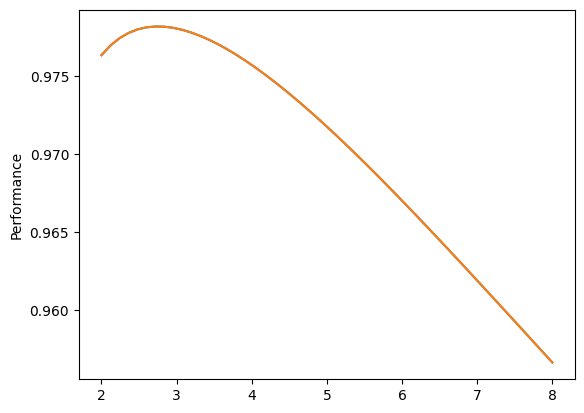

In [44]:
plt.plot(xs, all_recall)
plt.plot(xs, all_precision)
plt.ylabel("Performance")

Text(0, 0.5, 'Power')

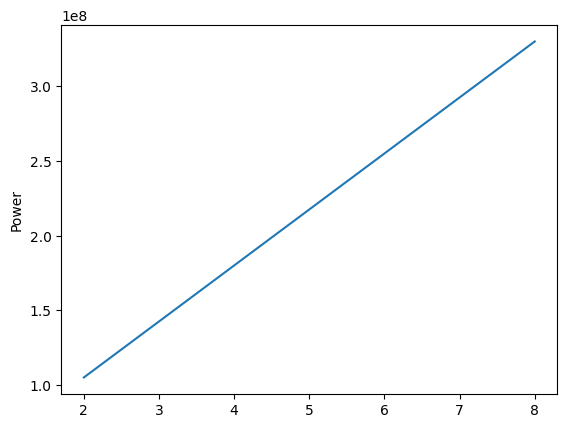

In [45]:
plt.plot(xs, res_p)
plt.ylabel("Power")